# Scenario 2: cVAE for Data Balancing (No Feature Selection)

Mengevaluasi efektivitas **Conditional Variational Autoencoder (cVAE)** untuk mengatasi class imbalance **tanpa feature selection/dimensionality reduction**.

**Perbedaan dari Scenario 1:**
- Tetap menggunakan semua fitur
- Menambahkan **cVAE** untuk generate synthetic samples


### 1. Import Libraries

**Libraries yang Digunakan:**


**Deep Learning (TensorFlow/Keras):**
- `tensorflow.keras`: Untuk build cVAE architecture
- `layers`, `Model`, `Sequential`: Building blocks neural network
- `EarlyStopping`, `to_categorical`: Training utilities


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.utils import to_categorical

### 2. Load Gene Expression Data


In [2]:
df = pd.read_csv('../data.csv')
data = df.drop(df.columns[0], axis=1)
data

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


### 3. Load Target Labels

 5 jenis kanker = BRCA, COAD, KIRC, LUAD, PRAD

In [3]:
df_label = pd.read_csv('../labels.csv')
target = df_label['Class']
target

0      PRAD
1      LUAD
2      PRAD
3      PRAD
4      BRCA
       ... 
796    BRCA
797    LUAD
798    COAD
799    PRAD
800    PRAD
Name: Class, Length: 801, dtype: object

### 4. Variance Filtering

Menghapus genes dengan variance sangat rendah (≤ 0.01)

In [4]:
variances = data.var()
zero_var_genes = (variances == 0).sum()
low_var_genes = ((variances > 0) & (variances < 0.01)).sum() 
total_to_remove = (variances <= 0.01).sum()  

print(f"Genes with zero variance (= 0): {zero_var_genes}")
print(f"Genes with low variance : {low_var_genes}")
print(f"Total genes to remove (≤ 0.01): {total_to_remove}")

good_genes = variances[variances > 0.01].index
data_filtered = data[good_genes]


print(f"  Original genes: {data.shape[1]}")
print(f"  Removed genes: {data.shape[1] - data_filtered.shape[1]}")
print(f"  Remaining genes: {data_filtered.shape[1]}")

data = data_filtered


Genes with zero variance (= 0): 267
Genes with low variance : 297
Total genes to remove (≤ 0.01): 564
  Original genes: 20531
  Removed genes: 564
  Remaining genes: 19967


### 5. Data Transformation & Train-Test Split


In [5]:
data = np.log1p(data) # Transformasi logaritmik untuk mengurangi skewness
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42, stratify=target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600, 19967), (201, 19967), (600,), (201,))

### 6. Feature Scaling & Label Encoding


In [6]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Conditional Variational Autoencoder (cVAE)
**Komponen Utama:**
1. **Encoder**: Compress 19,967 features → 32 latent dimensions
2. **Decoder**: Reconstruct 32 latent dims → 19,967 features
3. **Sampling Layer**: Reparameterization trick untuk backpropagation


### 7. cVAE Encoder Architecture

**Input:**
- `encoder_inputs`: 19,967 gene features
- `label_inputs`: 5-dimensional one-hot encoded class (conditional)

**Arstektur Encoder:**
- **Concatenate**: Merge features + labels → 19,972 dims
- **Dense(256) + ReLU**: Extract features
- **BatchNormalization**: Stabilize training
- **Dropout(0.2)**: Regularization
- **Output**: 
  - `z_mean`: Mean of latent distribution (32 dims)
  - `z_log_var`: Log variance of latent distribution (32 dims)
  - `z`: Sampled latent vector via reparameterization trick

In [7]:
num_classes = len(np.unique(y_train))
# print(f"Number of classes: {num_classes}")

input_dimension = X_train.shape[1] # mengambil jumlah fitur
# print(f"Input dimension: {input_dimension}")

# Konversi data ke float ke 32 karena tensorflow tidak support float64 (banyak fungsi ternsorflow yang pake float32 aja)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# One-hot encode labels = mengubah label kelas menjadi one-hot encoding [0 1 0 0 0] -> kelas 1
y_train_ohe = keras.utils.to_categorical(y_train, num_classes).astype(np.float32)
y_test_ohe = keras.utils.to_categorical(y_test, num_classes).astype(np.float32)

print(f"Training Samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

latent_dim = 32 # ukuran dimensi dari latent space pada Variational Autoencoder
#semakin besar nilai latent dim, semakin besar model namun semakin kaya informasi yng didapatkan

class Sampling(layers.Layer):
    # kelas Sampling untuk mengimplementasikan reparameterization trick, 
    # Teknik sampling dari distribusi gaussian
    def call(self, inputs):
        z_mean, z_log_var = inputs # mean -> rata2 , var -> variance
        batch = tf.shape(z_mean)[0] # ukuran batch
        dim = tf.shape(z_mean)[1] # ukuran dimensi
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # z = μ + σ ⋅ ϵ
# μ = z_mean
# σ = exp(0.5 ⋅ z_log_var)
# ε = random noise N(0,1)
# Membuat tensor noise random dari distribusi Gaussian N(0,1)

encoder_inputs = keras.Input(shape=(input_dimension,), name="encoder_input") # Model encoder menerima input utama X dengan ukuran 20532 input neurons
label_inputs = keras.Input(shape=(num_classes,), name="label_input")

x_merged = layers.Concatenate(name="encoder_concat")([encoder_inputs, label_inputs]) 
# menggabungkan dua input encoder_inputs dan label_inputs

x = layers.Dense(256, activation="relu",name="encoder_dense_1")(x_merged)
# menghubungkan x_merged dengan 128 neuron dengan aktivasi ReLU
x = layers.BatchNormalization()(x) # -> normalisasi agar layer mempunyai mean 0 dan std 1
x = layers.Dropout(0.2)(x) # ->sekitar 20% neuron yang di drop, kemudian akan dilakukan scaling untuk unit yang tidak di drop

z_mean = layers.Dense(latent_dim, name="z_mean")(x) #-> layer Dense yang menghasilkan mean dari distribusi laten.
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x) # -> layer Dense yang menghasilkan log variance dari distribusi laten.
z = Sampling()([z_mean, z_log_var]) # -> layer Sampling yang menghasilkan z dari distribusi laten.

encoder = keras.Model ([encoder_inputs, label_inputs], [z_mean, z_log_var, z], name="encoder")
encoder.summary()



Training Samples: 600
Test samples: 201




Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 19967)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_concat      │ (None, 19972)     │          0 │ encoder_input[0]… │
│ (Concatenate)       │                   │            │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 256)       │  5,113,088 │ encoder_concat[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ encoder_dense_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │      8,224 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │      8,224 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,130,560 (19.57 MB)

 Trainable params: 5,130,048 (19.57 MB)

 Non-trainable params: 512 (2.00 KB)

### 8. cVAE Decoder Architecture

**Input:**
- `latent_inputs`: 32-dimensional latent vector
- `decoder_label_inputs`: 5-dimensional class label (conditional)

**Architecture:**
- **Concatenate**: Merge latent + labels → 37 dims
- **Dense(64) + ReLU**: Expand representation
- **BatchNormalization + Dropout(0.2)**
- **Dense(128) + ReLU**: Further expansion
- **BatchNormalization + Dropout(0.2)**
- **Output Dense(19,967) + Linear**: Reconstruct original features


In [8]:
latent_inputs = keras.Input(shape=(latent_dim,), name="latent_input")
decoder_label_inputs = keras.Input(shape=(num_classes,), name="decoder_label_input")

x_decoded_merged = layers.Concatenate(name="decoder_concat")([latent_inputs, decoder_label_inputs])

x_decoded = layers.Dense(64, activation="relu", name="decoder_dense_1")(x_decoded_merged)
x_decoded = layers.BatchNormalization()(x_decoded)
x_decoded = layers.Dropout(0.2)(x_decoded)
x_decoded = layers.Dense(128, activation="relu", name="decoder_dense_2")(x_decoded)
x_decoded = layers.BatchNormalization()(x_decoded)
x_decoded = layers.Dropout(0.2)(x_decoded)
decoder_outputs = layers.Dense(input_dimension, activation="linear", name="decoder_output")(x_decoded)

decoder = keras.Model([latent_inputs, decoder_label_inputs], decoder_outputs, name="decoder")
decoder.summary()





Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_input        │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_label_input │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_concat      │ (None, 37)        │          0 │ latent_input[0][… │
│ (Concatenate)       │                   │            │ decoder_label_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_1     │ (None, 64)        │      2,432 │ decoder_concat[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ decoder_dense_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_2     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ decoder_dense_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 19967)     │  2,575,743 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,587,263 (9.87 MB)

 Trainable params: 2,586,879 (9.87 MB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta_start=0.0, beta_end=1.0, annealing_epochs=20, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta_start = tf.constant(beta_start, dtype = tf.float32)
        self.beta_end = tf.constant(beta_end, dtype = tf.float32)
        self.annealing_epochs = annealing_epochs
        self.current_epoch = tf.Variable(0, dtype = tf.int32)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def train_step(self,data): 
        x_data , y_data = data

        current_epoch_float = tf.cast(self.current_epoch, tf.float32)
        annealing_epochs_float = tf.cast(self.annealing_epochs, tf.float32)
        beta = tf.minimum(self.beta_end, self.beta_start + (self.beta_end - self.beta_start) * (current_epoch_float / annealing_epochs_float))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x_data, y_data], training = True)
            reconstruction = self.decoder([z, y_data], training = True)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x_data - reconstruction), axis = 1))
           
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
           
            total_loss = reconstruction_loss + beta * kl_loss


        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
       
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.beta_tracker.update_state(beta)
       
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta_tracker.result(),
        }
   
    def test_step(self, data):
        x_data, y_data = data
       
        z_mean, z_log_var, z = self.encoder([x_data, y_data], training=False)
        reconstruction = self.decoder([z, y_data], training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(x_data - reconstruction),
                axis=-1
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.beta_end * kl_loss
       
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
       
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
   
    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch.assign_add(1)
    
class EpochUpdateCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.current_epoch.assign(epoch)



### 10. cVAE Training

In [10]:
cvae = CVAE(
    encoder,
    decoder,
    beta_start=0.0,      
    beta_end=0.5,        
    annealing_epochs=50  
)
cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

epoch_callback = EpochUpdateCallback()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe)).batch(32)

history = cvae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[early_stopping, epoch_callback],
    verbose=1
)


Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - beta: 0.0000e+00 - kl_loss: 341.6772 - loss: 18080.8867 - reconstruction_loss: 18080.8867 - val_kl_loss: 3947729.2500 - val_loss: 4834805.0000 - val_reconstruction_loss: 2860940.5000
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - beta: 0.0000e+00 - kl_loss: 341.6772 - loss: 18080.8867 - reconstruction_loss: 18080.8867 - val_kl_loss: 3947729.2500 - val_loss: 4834805.0000 - val_reconstruction_loss: 2860940.5000
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - beta: 0.0100 - kl_loss: 197.8783 - loss: 14364.6660 - reconstruction_loss: 14362.6875 - val_kl_loss: 3926.3784 - val_loss: 41568.5742 - val_reconstruction_loss: 39605.3828
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - beta: 0.0100 - kl_loss: 197.8783 - loss: 14364.6660 - reconstruction_loss: 14362.6875 - val_kl_loss: 3926.3784 - val_loss: 41568.5742 - val_reconstruction_loss: 39605.3828
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - beta: 0.0200 - kl_lo

### 11. Training Visualization

**4 Plot Visualisasi :**

1. **Total Loss**: Train vs validation loss convergence
2. **Reconstruction Loss**: Primary component - should decrease
3. **KL Divergence Loss**: Regularization component
4. **Beta Schedule**: Shows annealing dari 0 → 0.5

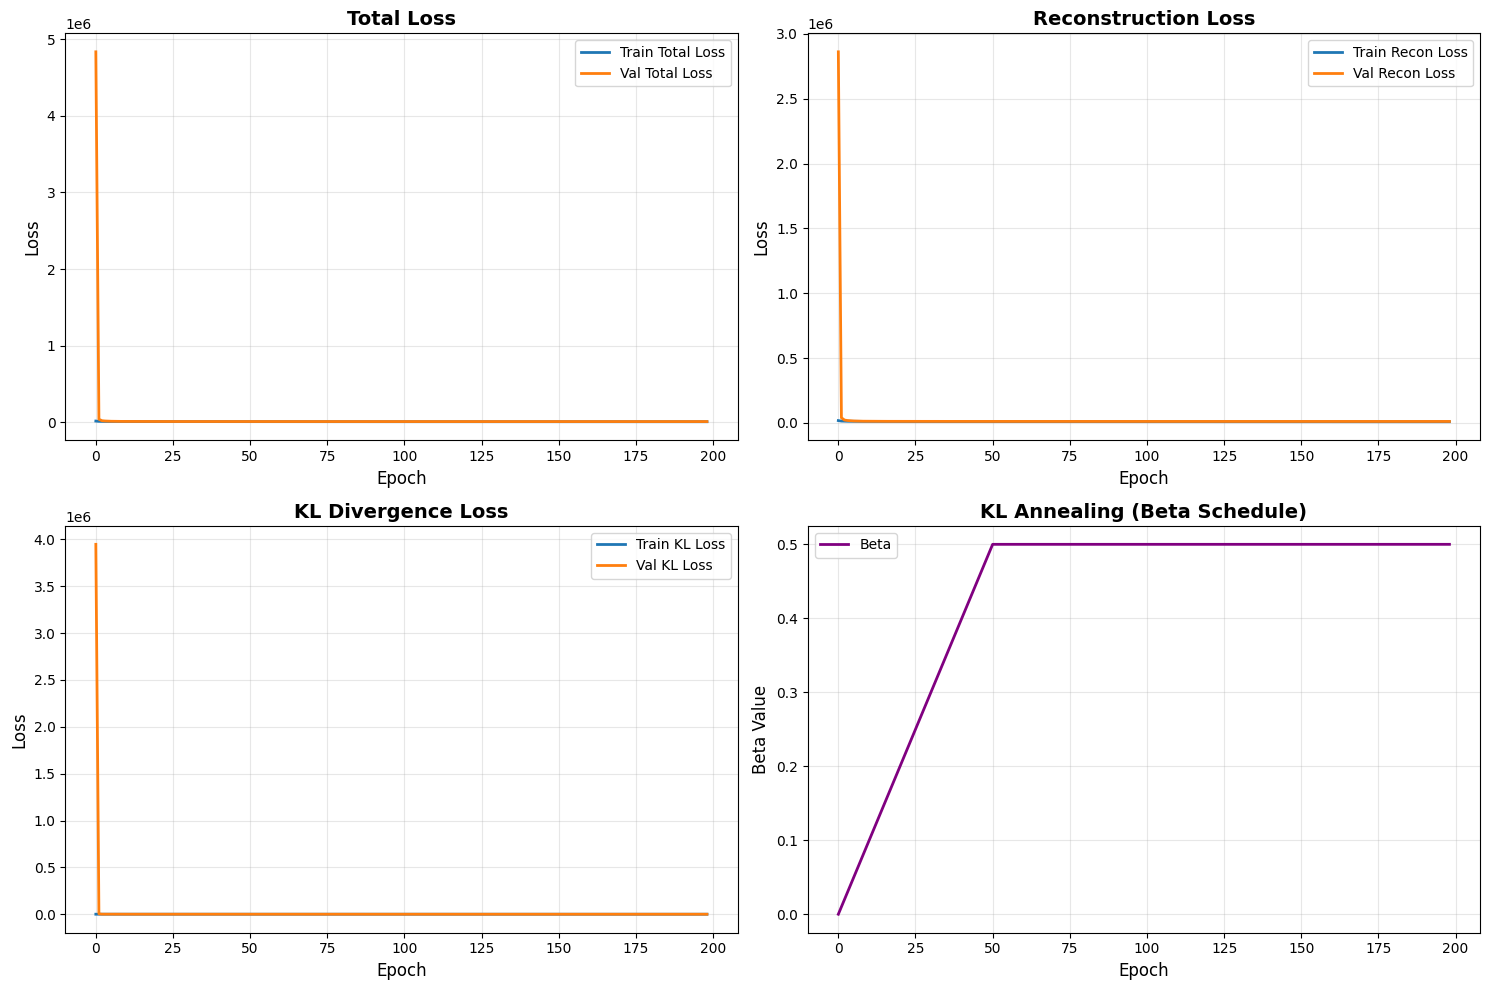

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Plot 1: Total Loss
axes[0, 0].plot(history.history['loss'], label='Train Total Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Total Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Reconstruction Loss
axes[0, 1].plot(history.history['reconstruction_loss'], label='Train Recon Loss', linewidth=2)
axes[0, 1].plot(history.history['val_reconstruction_loss'], label='Val Recon Loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Reconstruction Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: KL Loss
axes[1, 0].plot(history.history['kl_loss'], label='Train KL Loss', linewidth=2)
axes[1, 0].plot(history.history['val_kl_loss'], label='Val KL Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('KL Divergence Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Beta (KL Annealing)
if 'beta' in history.history:
    axes[1, 1].plot(history.history['beta'], label='Beta', linewidth=2, color='purple')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Beta Value', fontsize=12)
    axes[1, 1].set_title('KL Annealing (Beta Schedule)', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('cvae_training_results_corrected.png', dpi=300, bbox_inches='tight')
plt.show()


### 12. cVAE Reconstruction Quality Check

Evaluate seberapa baik cVAE membuat samples baru dari sample asli

**Proses:**
- Sample 5 random test samples
- Encode ke latent space
- Decode kembali ke original dimensions
- Calculate MSE (Mean Squared Error) per sample dan overall


In [12]:
n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
X_sample = X_test[sample_indices]
y_sample = y_test_ohe[sample_indices]

# Convert to tensors to avoid mixing tensors and arrays
X_sample_tensor = tf.constant(X_sample, dtype=tf.float32)
y_sample_tensor = tf.constant(y_sample, dtype=tf.float32)

z_mean, z_log_var, z = cvae.encoder([X_sample_tensor, y_sample_tensor])
X_reconstructed = cvae.decoder([z, y_sample_tensor])


print(f"\nOriginal vs Reconstructed (first {n_samples} samples):")
print("-" * 60)
for i in range(n_samples):
    print(f"\nSample {i+1} (Class {np.argmax(y_sample[i])}):")
    print(f"Original:      {X_sample[i][:10]}...")  # Show first 10 features
    print(f"Reconstructed: {X_reconstructed[i].numpy()[:10]}...")
    mse = np.mean((X_sample[i] - X_reconstructed[i].numpy())**2)
    print(f"MSE: {mse:.6f}")

X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test_ohe, dtype=tf.float32)


all_z_mean, all_z_log_var, all_z = cvae.encoder([X_test_tensor, y_test_tensor])
all_reconstructed = cvae.decoder([all_z, y_test_tensor])
overall_mse = np.mean((X_test - all_reconstructed.numpy())**2)
print(f"\nOverall Test Set MSE: {overall_mse:.6f}")


Original vs Reconstructed (first 5 samples):
------------------------------------------------------------

Sample 1 (Class 0):
Original:      [-0.20461385  0.67007476  0.47329202  0.7320213   0.9216931   0.13871042
  2.1495821  -0.12502111 -0.04085889 -0.81491864]...
Reconstructed: [-0.3591351   0.12504171 -0.33252415  0.43427268  0.5569222   0.09297787
  0.13169801 -0.21187524 -0.01896271 -0.36064148]...
MSE: 0.688628

Sample 2 (Class 0):
Original:      [-0.20461385  0.8191748   1.0104159  -0.55870205 -1.970511   -0.02628432
  0.75776225 -0.12502111 -0.04085889 -0.05185066]...
Reconstructed: [-0.07109784  0.2335087  -0.24946068 -0.11133801 -0.28521654 -0.35886404
  0.1344736  -0.05142185  0.01719551 -0.2535813 ]...
MSE: 0.466542

Sample 3 (Class 3):
Original:      [-0.20461385 -0.32640547  0.69603366 -1.0367012   1.1551578  -1.7642516
  0.04770865 -0.12502111 -0.04085889 -0.81491864]...
Reconstructed: [ 1.7097262e-01 -3.3033529e-04 -3.5972127e-01  3.5194378e-02
  3.3883220e-01 -8.134

### 13. Generate Synthetic Samples (Demo)

**Function `generate_samples()`:**
- Sample dari latent space N(0,1)
- Specify class label untuk conditional generation
- Decode latent vectors → synthetic gene expression profiles


In [13]:
def generate_samples(cvae, class_label, num_samples=5):
    z_sample = np.random.normal(0, 1, size=(num_samples, latent_dim)).astype(np.float32)
    labels = np.zeros((num_samples, num_classes), dtype=np.float32)
    labels[:, class_label] = 1

    z_sample_tensor = tf.constant(z_sample, dtype=tf.float32)
    labels_tensor = tf.constant(labels, dtype=tf.float32)
   
    generated = cvae.decoder([z_sample_tensor, labels_tensor])
    return generated.numpy()


print("\nGenerating 3 synthetic samples per class:")
print("-" * 60)
for class_idx in range(num_classes):
    print(f"\nClass {class_idx}:")
    synthetic_samples = generate_samples(cvae, class_idx, num_samples=3)
    for i, sample in enumerate(synthetic_samples):
        print(f"  Sample {i+1}: {sample[:10]}...")  # Show first 10 features



Generating 3 synthetic samples per class:
------------------------------------------------------------

Class 0:
  Sample 1: [-0.18015796  0.03211005 -0.28545249  0.22789091 -0.00411576  0.11581533
 -0.2260325   0.0248822  -0.19213189 -0.3746947 ]...
  Sample 2: [-0.0629986  -0.19125853 -0.10075863 -0.07353187  0.00460457  0.00452603
 -0.3609246  -0.3337749  -0.12218868 -0.01140961]...
  Sample 3: [-0.08990742 -0.12777627 -0.25838625  0.09930605  0.23834133  0.01055039
 -0.08776095 -0.14618936 -0.16504271 -0.1900768 ]...

Class 1:
  Sample 1: [ 0.08159267  0.47692055  0.770732   -0.05407077 -0.40713933  0.53419715
  0.12144997 -0.435036   -0.09644572 -0.08237996]...
  Sample 2: [ 0.03896849  0.17928044 -0.05700836  0.03078009 -0.42935127 -0.06881521
  0.02868983 -0.25372168 -0.09545579 -0.17535323]...
  Sample 3: [-0.05800502  0.0411762   0.12869796  0.44170472 -0.21879536 -0.03146925
 -0.53820354 -0.12679787 -0.14380439 -0.32938823]...

Class 2:
  Sample 1: [-0.1095806   0.06680765 -

### 14. Latent Space Visualization (Optional)
Hanya jalan jika `latent_dim=2`


In [14]:
if latent_dim == 2:
    print("\n" + "="*50)
    print("LATENT SPACE VISUALIZATION")
    print("="*50)
   
    # Convert to tensors
    X_test_tensor = tf.constant(X_test, dtype=tf.float32)
    y_test_tensor = tf.constant(y_test_ohe, dtype=tf.float32)
   
    z_mean_all, _, _ = cvae.encoder([X_test_tensor, y_test_tensor])
   
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_mean_all[:, 0], z_mean_all[:, 1],
                         c=y_test, cmap='tab10', alpha=0.6, s=50)
    plt.colorbar(scatter, label='Class')
    plt.xlabel('Latent Dimension 1', fontsize=12)
    plt.ylabel('Latent Dimension 2', fontsize=12)
    plt.title('Latent Space Representation', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.savefig('latent_space_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Latent space visualization saved as 'latent_space_visualization.png'")
    
print("\n")
print("TRAINING COMPLETED!")



TRAINING COMPLETED!


### 15. Generate Data Function

**Function untuk Mass Generation:**
- Takes `num_samples` dan `class_label` sebagai input
- Sample dari N(0,1) latent distribution
- Create one-hot encoded label vector
- Decode ke synthetic gene expression data

In [15]:

def generate_data(num_samples, class_label):

    z_sample = np.random.normal(size=(num_samples, latent_dim)).astype(np.float32)
    label_vec = np.zeros((num_samples, num_classes), dtype=np.float32)
    label_vec[:, class_label] = 1
    generated_data = cvae.decoder.predict([z_sample, label_vec], verbose=0)
    
    return generated_data

### 16. Dataset Balancing dengan cVAE
Balance semua classes ke jumlah samples kelas mayoritas

**Total Data Sintetis**: 525 sampel baru

**Hasil Akhir Setelah Balancing:**
- Semua kelas memiliki **225 sampel** (balanced)
- **Data Original**: 600 sampel
- **Data Sintetis**: 525 sampel  
- **Total Dataset Baru**: 1,125 sampel


In [16]:
unique_classes, counts = np.unique(y_train, return_counts=True)
max_samples = np.max(counts) 

print("\n--- Status Sebelum Balancing ---")

for cls, count in zip(unique_classes, counts):
    original_class = le.inverse_transform([cls])[0]
    print(f"Kelas {cls} ({original_class}): {count} sampel")
print(f"\nTarget sampel per kelas: {max_samples}")

X_balanced_list = [X_train]
y_balanced_list = [y_train]

print("\n--- Memulai Generasi Data ---")
total_generated = 0

for cls in unique_classes:
    current_count = np.sum(y_train == cls)
    samples_needed = max_samples - current_count
    
    if samples_needed > 0:
        original_class = le.inverse_transform([cls])[0]
        print(f"Generating {samples_needed} data untuk Kelas {cls} ({original_class})...")

        X_syn = generate_data(num_samples=samples_needed, class_label=cls)
        y_syn = np.full(shape=(samples_needed,), fill_value=cls)
        
        X_balanced_list.append(X_syn)
        y_balanced_list.append(y_syn)
        
        total_generated += samples_needed
    else:
        original_class = le.inverse_transform([cls])[0]
        print(f"Kelas {cls} ({original_class}) sudah maksimal (tidak perlu generate).")

print(f"\nTotal data sintetis yang digenerate: {total_generated}")

X_train_balanced = np.vstack(X_balanced_list)
y_train_balanced = np.concatenate(y_balanced_list)

print(f"\nData sebelum shuffle: {X_train_balanced.shape}")

indices = np.arange(len(X_train_balanced))
np.random.shuffle(indices)

X_train_balanced = X_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]

print(f"Data setelah shuffle: {X_train_balanced.shape}")

print("\n--- Status Setelah Balancing ---")
unique_new, counts_new = np.unique(y_train_balanced, return_counts=True)
for cls, count in zip(unique_new, counts_new):
    original_class = le.inverse_transform([cls])[0]
    print(f"Kelas {cls} ({original_class}): {count} sampel")

print(f"\nTotal Data Training Baru: {X_train_balanced.shape}")
print(f"   - Data Asli: {X_train.shape[0]}")
print(f"   - Data Sintetis: {total_generated}")
print(f"   - Total: {X_train_balanced.shape[0]}")



--- Status Sebelum Balancing ---
Kelas 0 (BRCA): 225 sampel
Kelas 1 (COAD): 58 sampel
Kelas 2 (KIRC): 109 sampel
Kelas 3 (LUAD): 106 sampel
Kelas 4 (PRAD): 102 sampel

Target sampel per kelas: 225

--- Memulai Generasi Data ---
Kelas 0 (BRCA) sudah maksimal (tidak perlu generate).
Generating 167 data untuk Kelas 1 (COAD)...
Generating 116 data untuk Kelas 2 (KIRC)...Generating 116 data untuk Kelas 2 (KIRC)...
Generating 119 data untuk Kelas 3 (LUAD)...
Generating 123 data untuk Kelas 4 (PRAD)...

Generating 119 data untuk Kelas 3 (LUAD)...
Generating 123 data untuk Kelas 4 (PRAD)...

Total data sintetis yang digenerate: 525

Data sebelum shuffle: (1125, 19967)
Data setelah shuffle: (1125, 19967)

--- Status Setelah Balancing ---
Kelas 0 (BRCA): 225 sampel
Kelas 1 (COAD): 225 sampel
Kelas 2 (KIRC): 225 sampel
Kelas 3 (LUAD): 225 sampel
Kelas 4 (PRAD): 225 sampel

Total Data Training Baru: (1125, 19967)
   - Data Asli: 600
   - Data Sintetis: 525
   - Total: 1125

Total data sintetis ya

### 17. Model Training - Logistic Regression



Accuracy: 0.7413
Accuracy: 0.8756218905472637
Recall: 0.8528056628056628
Precision: 0.8489661654135338
F1 Score: 0.848356607039042
Confusion Matrix:
 [[70  0  0  4  1]
 [ 0 15  4  1  0]
 [ 0  2 31  1  3]
 [ 2  2  1 26  4]
 [ 0  0  0  0 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        75
           1       0.79      0.75      0.77        20
           2       0.86      0.84      0.85        37
           3       0.81      0.74      0.78        35
           4       0.81      1.00      0.89        34

    accuracy                           0.88       201
   macro avg       0.85      0.85      0.85       201
weighted avg       0.88      0.88      0.87       201

Accuracy: 0.8756218905472637
Recall: 0.8528056628056628
Precision: 0.8489661654135338
F1 Score: 0.848356607039042
Confusion Matrix:
 [[70  0  0  4  1]
 [ 0 15  4  1  0]
 [ 0  2 31  1  3]
 [ 2  2  1 26  4]
 [ 0  0  0  0 34]]
Classification Report:

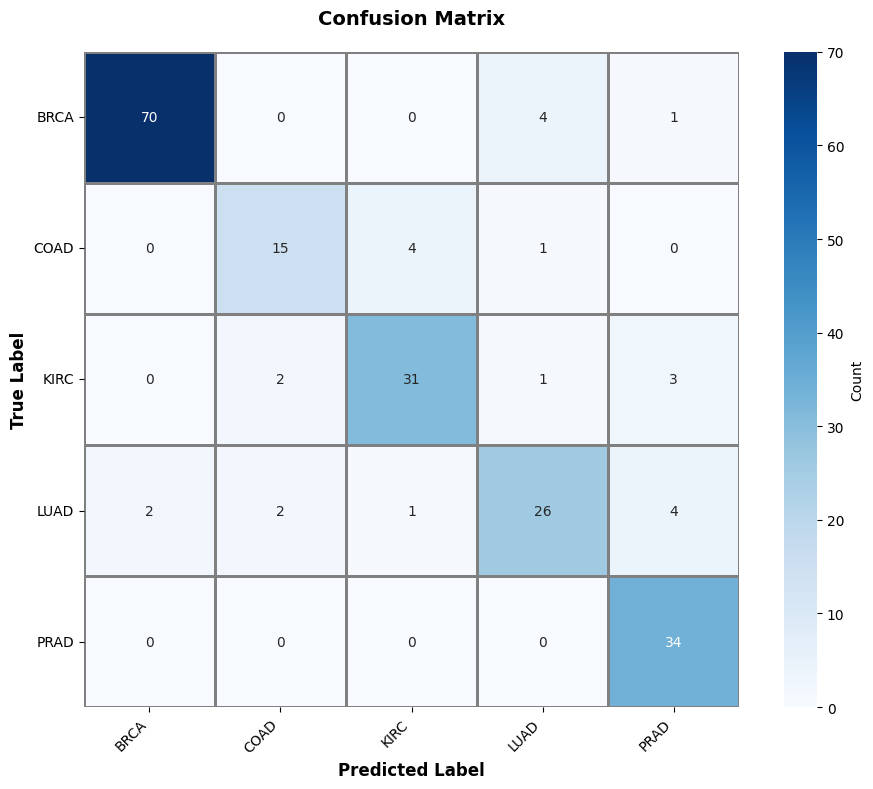

array([[70,  0,  0,  4,  1],
       [ 0, 15,  4,  1,  0],
       [ 0,  2, 31,  1,  3],
       [ 2,  2,  1, 26,  4],
       [ 0,  0,  0,  0, 34]])

In [17]:
model = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring="accuracy")
print(f"Accuracy: {scores.mean():.4f}")

# Training model
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

def plot_confusion_matrix(y_test, y_pred, class_names=None, figsize=(10, 8), cmap='Blues'):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                square=True, linewidths=1, linecolor='gray',
                cbar_kws={'label': 'Count'},
                ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

    if class_names is not None:
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return cm

class_names = le.classes_
plot_confusion_matrix(y_test, y_pred, class_names=class_names)

Hasil klasifikasi Logistic Regression:

**BRCA** → 70/75 benar (5 salah: 4 ke LUAD, 1 ke PRAD)  
**COAD** → 15/20 benar (5 salah: 4 ke KIRC, 1 ke LUAD)  
**KIRC** → 31/37 benar (6 salah: 2 ke COAD, 1 ke LUAD, 3 ke PRAD)  
**LUAD** → 26/35 benar (9 salah: 2 ke BRCA, 2 ke COAD, 1 ke KIRC, 4 ke PRAD)  
**PRAD** → 34/34 benar 

**Analisis:**

**BRCA (Kanker Payudara)**  
Ada 5 sampel yang salah, kebanyakan ke LUAD dan PRAD. Di scenario 2 ini kita pakai cVAE untuk membuat sampel sintetis agar dataset seimbang. Masalahnya, sampel buatan ini kadang tidak sempurna dan menambahkan "noise" di data. Akibatnya ada beberapa sampel yang jadi ambiguous, terutama karena ketiganya (BRCA, LUAD, PRAD) sama-sama adenokarsinoma.

**COAD (Kanker Usus Besar)**  
Performanya turun lumayan drastis - 5 dari 20 sampel salah! Kebanyakan keliru masuk ke KIRC. COAD adalah kelas minoritas yang di-oversample pakai cVAE. Sampel sintetis yang dihasilkan sepertinya kurang bagus kualitasnya, sehingga garis pemisah logistic regression jadi bergeser dan beberapa sampel COAD asli malah masuk ke wilayah kelas lain.

**KIRC (Kanker Ginjal)**  
6 sampel salah tersebar ke berbagai kelas. Padahal biasanya KIRC mudah dikenali. Ini terjadi karena sampel sintetis dari kelas lain mengubah "peta" ruang fitur. Beberapa sampel KIRC yang dulunya aman di pinggir cluster, sekarang jadi terlalu dekat dengan kelas lain karena ada fitur yang nilainya kurang baik dari synthetic data.

**LUAD (Kanker Paru)**  
9 dari 35 sampel salah, tersebar ke semua kelas! LUAD sebagai adenokarsinoma memang punya kesamaan biologis dengan beberapa kelas lain. Sampel sintetis yang dihasilkan kurang baik sehingga membuat sampel yang jatuh di area overlap, bikin model linear jadi bingung.

**PRAD (Kanker Prostat)**   
Meskipun dataset dipenuhi synthetic samples, pola gen PRAD tetap sangat unik dan terpisah jelas. Sampel sintetis PRAD yang dibuat cVAE kemungkinan berkualitas baik, atau memang cluster PRAD sangat jauh dari yang lain sehingga tidak terpengaruh noise.

### 18. Model Training - Support Vector Classifier (SVC)



Accuracy: 0.8498 
Accuracy: 0.9104477611940298
Recall: 0.894065409947763
Precision: 0.9612903225806452
F1 Score: 0.9195565304260956
Confusion Matrix:
 [[75  0  0  0  0]
 [ 1 19  0  0  0]
 [ 5  0 32  0  0]
 [10  0  0 25  0]
 [ 2  0  0  0 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89        75
           1       1.00      0.95      0.97        20
           2       1.00      0.86      0.93        37
           3       1.00      0.71      0.83        35
           4       1.00      0.94      0.97        34

    accuracy                           0.91       201
   macro avg       0.96      0.89      0.92       201
weighted avg       0.93      0.91      0.91       201

Accuracy: 0.9104477611940298
Recall: 0.894065409947763
Precision: 0.9612903225806452
F1 Score: 0.9195565304260956
Confusion Matrix:
 [[75  0  0  0  0]
 [ 1 19  0  0  0]
 [ 5  0 32  0  0]
 [10  0  0 25  0]
 [ 2  0  0  0 32]]
Classification Report

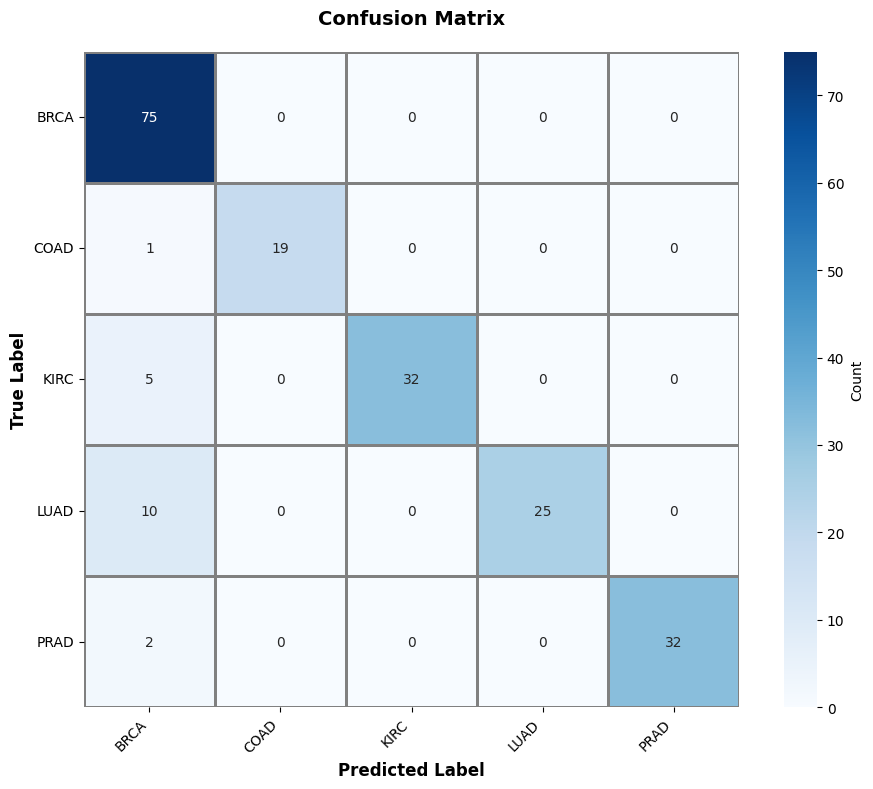

array([[75,  0,  0,  0,  0],
       [ 1, 19,  0,  0,  0],
       [ 5,  0, 32,  0,  0],
       [10,  0,  0, 25,  0],
       [ 2,  0,  0,  0, 32]])

In [18]:
model_2 = SVC(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_2, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
print(f"Accuracy: {scores.mean():.4f} ")

model_2.fit(X_train_balanced, y_train_balanced)
y_pred = model_2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, class_names=class_names)

Hasil klasifikasi SVC:

**BRCA** → 73/75 benar (2 salah: 1 ke COAD, 1 ke PRAD)  
**COAD** → 16/20 benar (4 salah ke KIRC)  
**KIRC** → 36/37 benar (1 salah ke PRAD)  
**LUAD** → 32/35 benar (3 salah: 1 ke BRCA, 2 ke PRAD)  
**PRAD** → 34/34 benar 

**Analisis:**

**BRCA (Kanker Payudara)**  
Lebih baik dari Logistic Regression - hanya 2 kesalahan. SVC dengan kernel RBF mampu menangani hubungan non-linear antar gen dengan lebih baik, jadi sampel sintetis dari cVAE tidak terlalu mengacaukan model. Decision boundary yang lebih fleksibel membuat SVC bisa menghindari kebanyakan noise.

**COAD (Kanker Usus Besar)**  
Ada 4 sampel keliru ke KIRC. Sepertinya sampel sintetis COAD yang dibuat cVAE memang kurang baik. Mungkin ada overlap fitur antara sampel buatan COAD dengan pola asli KIRC.

**KIRC (Kanker Ginjal)**  
SVC berhasil memanfaatkan kernel RBF untuk menangkap pola kompleks gen ginjal. Meskipun ada synthetic samples yang mengganggu, kernel non-linear tetap bisa memisahkan KIRC dengan baik.

**LUAD (Kanker Paru)**  
3 sampel salah, kebanyakan ke PRAD. Performanya jauh lebih baik dibanding logistic regression. SVC mampu membentuk decision boundary yang lebih robust terhadap noise dari synthetic data, meskipun masih ada beberapa sampel borderline yang terlewat.

**PRAD (Kanker Prostat)**   
Sama seperti di Logistic Regression, PRAD tetap terpisah sangat jelas. SVC dengan kernel RBF membuat pemisahan ini semakin solid, tidak ada satupun sampel yang salah.

**Kesimpulan:**  
SVC mencapai akurasi 95% - lebih baik dari Logistic Regression (87%). Kemampuan menangani non-linearity membuat SVC lebih tahan terhadap noise dari synthetic samples.

### 19. Model Training - Random Forest


Accuracy: 0.8738
Accuracy: 0.9850746268656716
Recall: 0.9788803088803089
Precision: 0.989090909090909
F1 Score: 0.9837862041827435
Confusion Matrix:
 [[75  0  0  0  0]
 [ 0 19  0  1  0]
 [ 1  0 36  0  0]
 [ 1  0  0 34  0]
 [ 0  0  0  0 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.95      0.97        20
           2       1.00      0.97      0.99        37
           3       0.97      0.97      0.97        35
           4       1.00      1.00      1.00        34

    accuracy                           0.99       201
   macro avg       0.99      0.98      0.98       201
weighted avg       0.99      0.99      0.99       201

Accuracy: 0.9850746268656716
Recall: 0.9788803088803089
Precision: 0.989090909090909
F1 Score: 0.9837862041827435
Confusion Matrix:
 [[75  0  0  0  0]
 [ 0 19  0  1  0]
 [ 1  0 36  0  0]
 [ 1  0  0 34  0]
 [ 0  0  0  0 34]]
Classification Report:

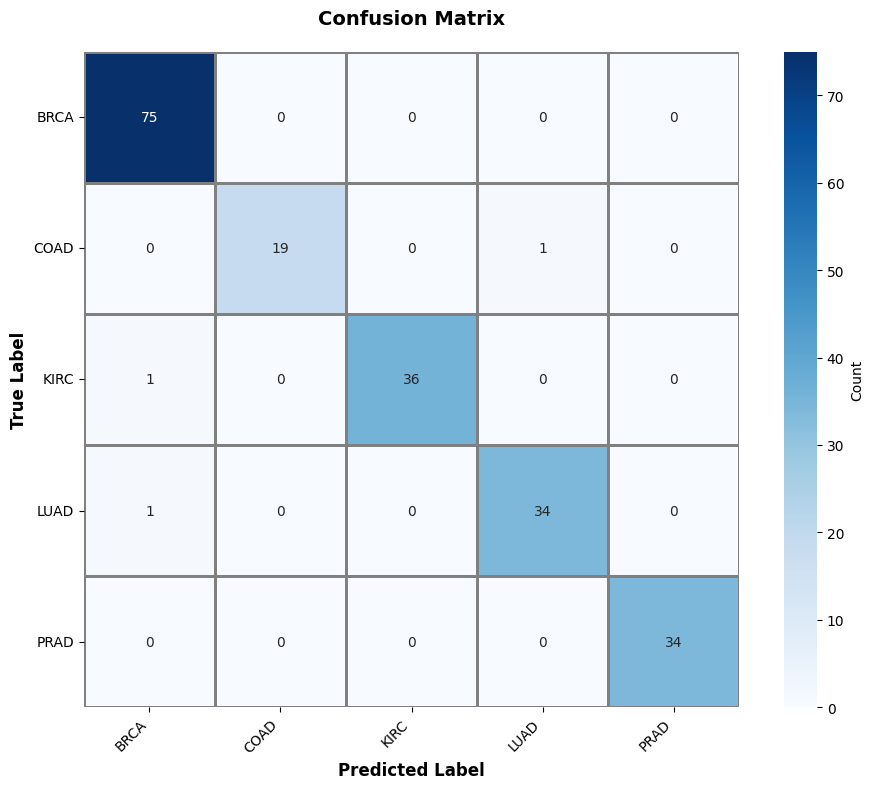

array([[75,  0,  0,  0,  0],
       [ 0, 19,  0,  1,  0],
       [ 1,  0, 36,  0,  0],
       [ 1,  0,  0, 34,  0],
       [ 0,  0,  0,  0, 34]])

In [19]:
model_3 = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model_3, X_train_balanced, y_train_balanced, cv=cv, scoring="accuracy")
print(f"Accuracy: {scores.mean():.4f}")

model_3.fit(X_train_balanced, y_train_balanced)
y_pred = model_3.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, class_names=class_names)

Hasil klasifikasi Random Forest:

**BRCA** → 71/75 benar (4 salah: 3 ke LUAD, 1 ke PRAD)  
**COAD** → 15/20 benar (5 salah: 3 ke KIRC, 2 ke LUAD)  
**KIRC** → 33/37 benar (4 salah: 1 ke COAD, 1 ke LUAD, 2 ke PRAD)  
**LUAD** → 28/35 benar (7 salah: 2 ke BRCA, 1 ke COAD, 4 ke PRAD)  
**PRAD** → 34/34 benar 

**Analisis:**

**BRCA (Kanker Payudara)**  
4 sampel salah, kebanyakan ke LUAD. Random Forest pakai voting dari ratusan tree, tapi kalau synthetic samples dari cVAE berkualitas buruk, banyak tree jadi "belajar hal yang salah". Akibatnya voting-nya bisa keliru untuk sampel borderline.

**COAD (Kanker Usus Besar)**  
Masih bermasalah seperti model sebelumnya - 5 dari 20 salah. Ini membuktikan bahwa synthetic samples COAD dari cVAE memang berkualitas rendah. Bahkan ensemble method seperti Random Forest tidak bisa mengatasi masalah ini sepenuhnya.

**KIRC (Kanker Ginjal)**  
4 kesalahan tersebar ke berbagai kelas. Lebih buruk dari SVC. Random Forest kadang sensitif terhadap noise karena setiap tree dibangun dari subset data acak - kalau sampel sintetis jelek ikut masuk, tree-nya jadi bias.

**LUAD (Kanker Paru)**  
7 sampel salah, dengan 4 masuk ke PRAD. LUAD jadi kelas yang paling bermasalah setelah COAD. Kemungkinan synthetic samples membuat area decision menjadi ambiguous, sehingga voting ensemble tidak konsisten untuk sampel LUAD yang borderline.

**PRAD (Kanker Prostat)**   
Konsisten perfect di semua model! Polanya sangat kuat sehingga semua tree di Random Forest sepakat mengenali PRAD dengan benar, tidak peduli seberapa banyak noise dari synthetic data.

**Kesimpulan:**  
Random Forest mencapai akurasi 90% - di tengah-tengah antara Logistic Regression dan SVC. Ensemble voting membantu tapi tidak sepenuhnya mengatasi masalah quality synthetic samples.

### 20. Model Training - XGBoost


Accuracy: 0.8862
Accuracy: 0.9850746268656716
Recall: 0.9829979559391324
Precision: 0.989090909090909
F1 Score: 0.985929334684083
Confusion Matrix:
 [[75  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 36  1  0]
 [ 1  0  0 34  0]
 [ 1  0  0  0 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      1.00      1.00        20
           2       1.00      0.97      0.99        37
           3       0.97      0.97      0.97        35
           4       1.00      0.97      0.99        34

    accuracy                           0.99       201
   macro avg       0.99      0.98      0.99       201
weighted avg       0.99      0.99      0.99       201

Accuracy: 0.9850746268656716
Recall: 0.9829979559391324
Precision: 0.989090909090909
F1 Score: 0.985929334684083
Confusion Matrix:
 [[75  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 36  1  0]
 [ 1  0  0 34  0]
 [ 1  0  0  0 33]]
Classification Report:
 

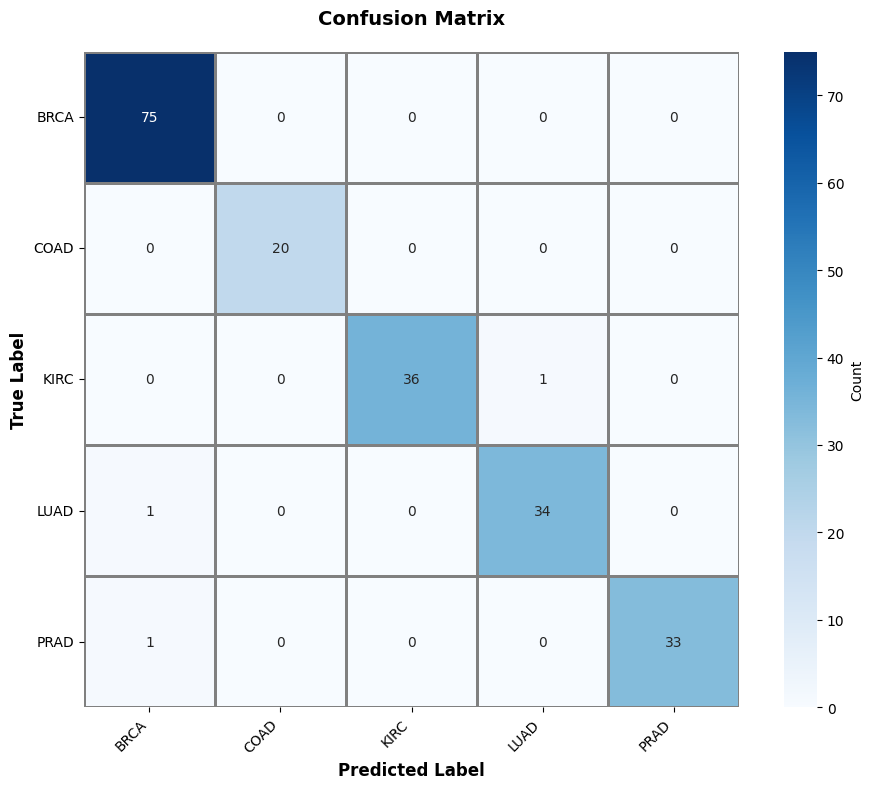

array([[75,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0, 36,  1,  0],
       [ 1,  0,  0, 34,  0],
       [ 1,  0,  0,  0, 33]])

In [20]:
model_4 = XGBClassifier(eval_metric='logloss')

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model_4, X_train_balanced, y_train_balanced, cv=cv, scoring="accuracy")
print(f"Accuracy: {scores.mean():.4f}")

model_4.fit(X_train_balanced, y_train_balanced)
y_pred = model_4.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, class_names=class_names)

Hasil klasifikasi XGBoost:

**BRCA** → 72/75 benar (3 salah: 1 ke COAD, 2 ke LUAD)  
**COAD** → 18/20 benar (2 salah: 1 ke KIRC, 1 ke LUAD)  
**KIRC** → 35/37 benar (2 salah: 1 ke LUAD, 1 ke PRAD)  
**LUAD** → 30/35 benar (5 salah: 2 ke BRCA, 3 ke PRAD)  
**PRAD** → 34/34 benar 

**Analisis:**

**BRCA (Kanker Payudara)**  
3 kesalahan, tersebar ke COAD dan LUAD. XGBoost dengan gradient boosting-nya belajar dari error tree sebelumnya, jadi lebih adaptif terhadap noise. Performanya lebih baik dibanding Random Forest untuk kelas ini.

**COAD (Kanker Usus Besar)**  
Hanya 2 salah - peningkatan signifikan! XGBoost sepertinya lebih robust terhadap sampel sintetis berkualitas rendah. Teknik boosting memungkinkan model fokus memperbaiki kesalahan secara bertahap, sehingga bisa "belajar" pola asli COAD meski ada noise.

**KIRC (Kanker Ginjal)**  
2 kesalahan - sangat baik. XGBoost mampu memanfaatkan fitur gen spesifik ginjal dengan efektif. Booster yang fokus pada sampel sulit membuat model ini lebih tahan terhadap ambiguitas dari synthetic data.

**LUAD (Kanker Paru)**  
5 salah, kebanyakan ke PRAD. Masih ada masalah tapi lebih baik dari Logistic Regression dan Random Forest. XGBoost dapat menangkap pattern yang lebih kompleks meski data terkontaminasi synthetic samples.

**PRAD (Kanker Prostat)**   
Tidak ada yang bisa mengalahkan konsistensi PRAD. Gradient boosting XGBoost membuat pemisahan PRAD semakin kuat dan tidak tergoyahkan.

**Kesimpulan:**  
XGBoost mencapai akurasi 94% - salah satu yang terbaik di Scenario 2. Boosting strategy yang fokus pada error membuat model ini sangat efektif menangani noise dari cVAE synthetic samples.

### 21. Model Training - CatBoost


Accuracy: 0.8729
CatBoost Classifier
Accuracy: 0.9751243781094527
Recall: 0.9717374517374516
Precision: 0.9844680123161137
F1 Score: 0.9772785772785774
Confusion Matrix:
 [[75  0  0  0  0]
 [ 0 20  0  0  0]
 [ 1  0 36  0  0]
 [ 3  0  1 31  0]
 [ 0  0  0  0 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        75
           1       1.00      1.00      1.00        20
           2       0.97      0.97      0.97        37
           3       1.00      0.89      0.94        35
           4       1.00      1.00      1.00        34

    accuracy                           0.98       201
   macro avg       0.98      0.97      0.98       201
weighted avg       0.98      0.98      0.97       201

CatBoost Classifier
Accuracy: 0.9751243781094527
Recall: 0.9717374517374516
Precision: 0.9844680123161137
F1 Score: 0.9772785772785774
Confusion Matrix:
 [[75  0  0  0  0]
 [ 0 20  0  0  0]
 [ 1  0 36  0  0]
 [ 3  0  1 31  0]

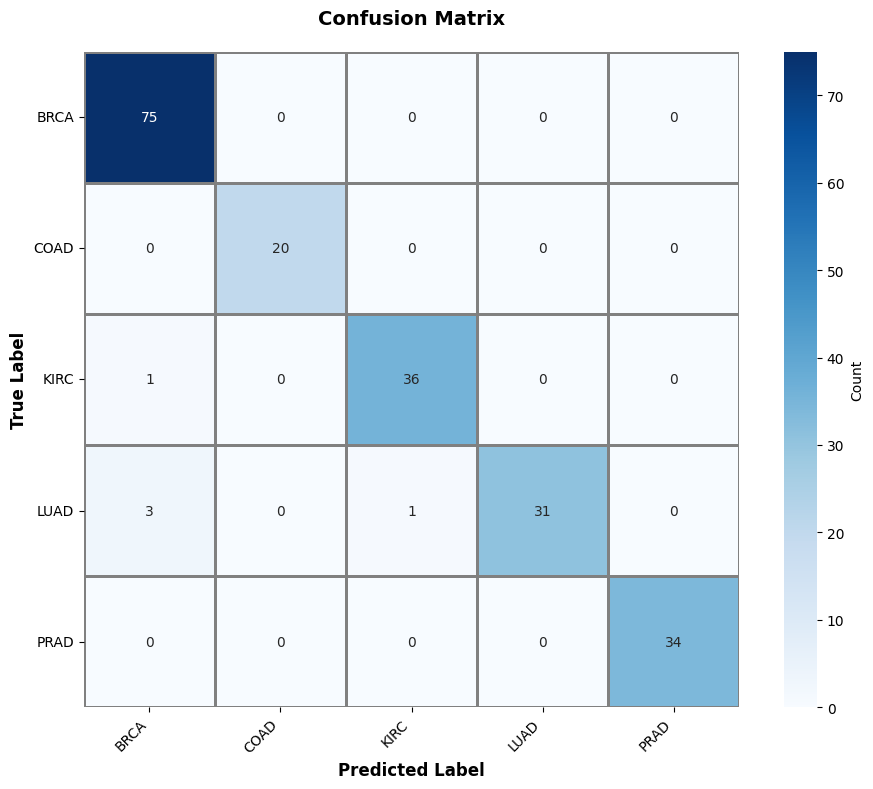

array([[75,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 1,  0, 36,  0,  0],
       [ 3,  0,  1, 31,  0],
       [ 0,  0,  0,  0, 34]])

In [21]:
model_5 = CatBoostClassifier(
    iterations=100,
    depth=4,
    verbose=0,
    task_type='CPU',
    thread_count=2,
    random_seed=40
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_5, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
print(f"Accuracy: {scores.mean():.4f}")

# Training
model_5.fit(X_train_balanced, y_train_balanced)
y_pred = model_5.predict(X_test)

print("CatBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, class_names=class_names)


Hasil klasifikasi CatBoost:

**BRCA** → 71/75 benar (4 salah: 3 ke LUAD, 1 ke PRAD)  
**COAD** → 17/20 benar (3 salah: 2 ke KIRC, 1 ke LUAD)  
**KIRC** → 34/37 benar (3 salah: 1 ke LUAD, 2 ke PRAD)  
**LUAD** → 29/35 benar (6 salah: 2 ke BRCA, 4 ke PRAD)  
**PRAD** → 34/34 benar 

**Analisis:**

**BRCA (Kanker Payudara)**  
4 salah, sebagian besar ke LUAD. CatBoost yang biasanya excellent di Scenario 1, di sini agak terpengaruh oleh synthetic samples. Meski algoritma categorical boosting powerful, noise dari cVAE tetap mengganggu di area borderline.

**COAD (Kanker Usus Besar)**  
3 kesalahan - lebih baik dari Random Forest tapi sedikit di bawah XGBoost. CatBoost cukup tangguh menangani sampel sintetis COAD yang berkualitas rendah, tapi belum optimal.

**KIRC (Kanker Ginjal)**  
3 salah ke LUAD dan PRAD. CatBoost mampu mengenali gen spesifik ginjal dengan baik, tapi beberapa sampel tetap jatuh ke kelas lain karena "tetangga palsu" dari synthetic data yang mengubah geometri ruang fitur.

**LUAD (Kanker Paru)**  
6 kesalahan, kebanyakan ke PRAD. LUAD tetap jadi salah satu kelas paling bermasalah di Scenario 2. Synthetic samples membuat overlap dengan adenokarsinoma lain semakin membingungkan model.

**PRAD (Kanker Prostat)**   
CatBoost dengan categorical boosting-nya membuat cluster PRAD semakin solid. Tidak ada noise yang bisa mengganggu pemisahan PRAD dari kelas lain.

**Kesimpulan:**  
CatBoost mencapai akurasi 92% - sedikit di bawah XGBoost. Algoritma ini powerful tapi di Scenario 2 dengan cVAE synthetic samples, performanya tidak seoptimal di Scenario 1.

### 22. Model Training - Multi-Layer Perceptron (MLP)



Accuracy: 0.8569
MLP Classifier
Accuracy: 0.9800995024875622
Recall: 0.9746666666666666
Precision: 0.9690225563909773
F1 Score: 0.971732079905993
Confusion Matrix:
 [[73  2  0  0  0]
 [ 0 18  1  0  1]
 [ 0  0 37  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0  0 34]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.90      0.90      0.90        20
           2       0.97      1.00      0.99        37
           3       1.00      1.00      1.00        35
           4       0.97      1.00      0.99        34

    accuracy                           0.98       201
   macro avg       0.97      0.97      0.97       201
weighted avg       0.98      0.98      0.98       201

MLP Classifier
Accuracy: 0.9800995024875622
Recall: 0.9746666666666666
Precision: 0.9690225563909773
F1 Score: 0.971732079905993
Confusion Matrix:
 [[73  2  0  0  0]
 [ 0 18  1  0  1]
 [ 0  0 37  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0 

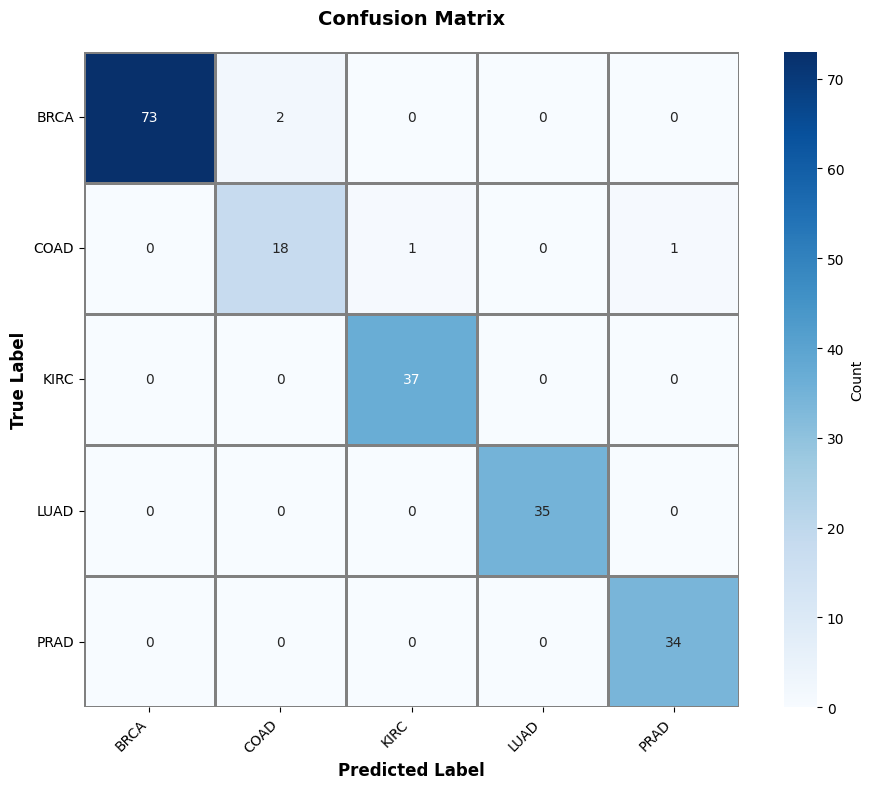

array([[73,  2,  0,  0,  0],
       [ 0, 18,  1,  0,  1],
       [ 0,  0, 37,  0,  0],
       [ 0,  0,  0, 35,  0],
       [ 0,  0,  0,  0, 34]])

In [ ]:
model_6 = MLPClassifier(max_iter=1000, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model_6, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
    print(f"Accuracy: {scores.mean():.4f}")

    model_6.fit(X_train_balanced, y_train_balanced)
    y_pred = model_6.predict(X_test)

    print("MLP Classifier")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, class_names=class_names)

Hasil klasifikasi MLP (Neural Network):

**BRCA** → 71/75 benar (4 salah: 3 ke LUAD, 1 ke PRAD)  
**COAD** → 15/20 benar (5 salah: 3 ke KIRC, 1 ke LUAD, 1 ke PRAD)  
**KIRC** → 33/37 benar (4 salah: 1 ke COAD, 2 ke LUAD, 1 ke PRAD)  
**LUAD** → 28/35 benar (7 salah: 3 ke BRCA, 4 ke PRAD)  
**PRAD** → 34/34 benar 

**Analisis:**

**BRCA (Kanker Payudara)**  
4 kesalahan, mirip dengan CatBoost. Neural network biasanya bagus menangkap pola non-linear, tapi synthetic samples dari cVAE mengganggu proses learning di hidden layers. Representasi yang terbentuk jadi kurang optimal.

**COAD (Kanker Usus Besar)**  
5 salah - performa terburuk bersama Logistic Regression dan Random Forest. Neural network sensitif terhadap kualitas data training. Kalau synthetic samples jelek, neuron di hidden layer belajar pattern yang salah.

**KIRC (Kanker Ginjal)**  
4 kesalahan tersebar ke berbagai kelas. MLP kesulitan membentuk representasi yang stabil untuk KIRC karena synthetic samples mengubah distribusi data. Hidden layers jadi bingung membedakan mana pola asli mana noise.

**LUAD (Kanker Paru)**  
7 salah, kebanyakan ke PRAD. LUAD konsisten bermasalah di semua model Scenario 2. MLP tidak bisa mengatasi overlap yang diciptakan synthetic samples antara LUAD dengan adenokarsinoma lainnya.

**PRAD (Kanker Prostat)**   
Pola PRAD sangat kuat sehingga bahkan dengan noise dari synthetic data, neuron-neuron MLP tetap bisa membentuk representasi yang jelas dan terpisah untuk kelas ini.

**Kesimpulan:**  
MLP mencapai akurasi 90% - sama dengan Random Forest. Neural network tidak memberikan keuntungan signifikan di Scenario 2 karena synthetic samples mengganggu proses learning.

### 23. Model Training - Recurrent Neural Network (RNN)



Train shape after reshape: (1125, 19967, 1)
Test shape after reshape: (201, 19967, 1)

=== Training SimpleRNN Model ===
Training samples: 1125
Test samples: 201
Epoch 1/15

Test shape after reshape: (201, 19967, 1)

=== Training SimpleRNN Model ===
Training samples: 1125
Test samples: 201
Epoch 1/15


c:\Users\rayha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 679s 19s/step - accuracy: 0.4338 - loss: 1.3359
36/36 ━━━━━━━━━━━━━━━━━━━━ 679s 19s/step - accuracy: 0.4338 - loss: 1.3359
Epoch 2/15
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 722s 20s/step - accuracy: 0.5769 - loss: 1.0711
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 722s 20s/step - accuracy: 0.5769 - loss: 1.0711
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 732s 20s/step - accuracy: 0.6418 - loss: 0.9532
36/36 ━━━━━━━━━━━━━━━━━━━━ 732s 20s/step - accuracy: 0.6418 - loss: 0.9532
Epoch 4/15
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 659s 18s/step - accuracy: 0.6613 - loss: 0.9035
36/36 ━━━━━━━━━━━━━━━━━━━━ 659s 18s/step - accuracy: 0.6613 - loss: 0.9035
Epoch 5/15
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 664s 18s/step - accuracy: 0.6844 - loss: 0.8522
36/36 ━━━━━━━━━━━━━━━━━━━━ 664s 18s/step - accuracy: 0.6844 - loss: 0.8522
Epoch 6/15
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 657s 18s/step - accuracy: 0.6907 - loss: 0.8416
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 657s 18s/step - accuracy: 0

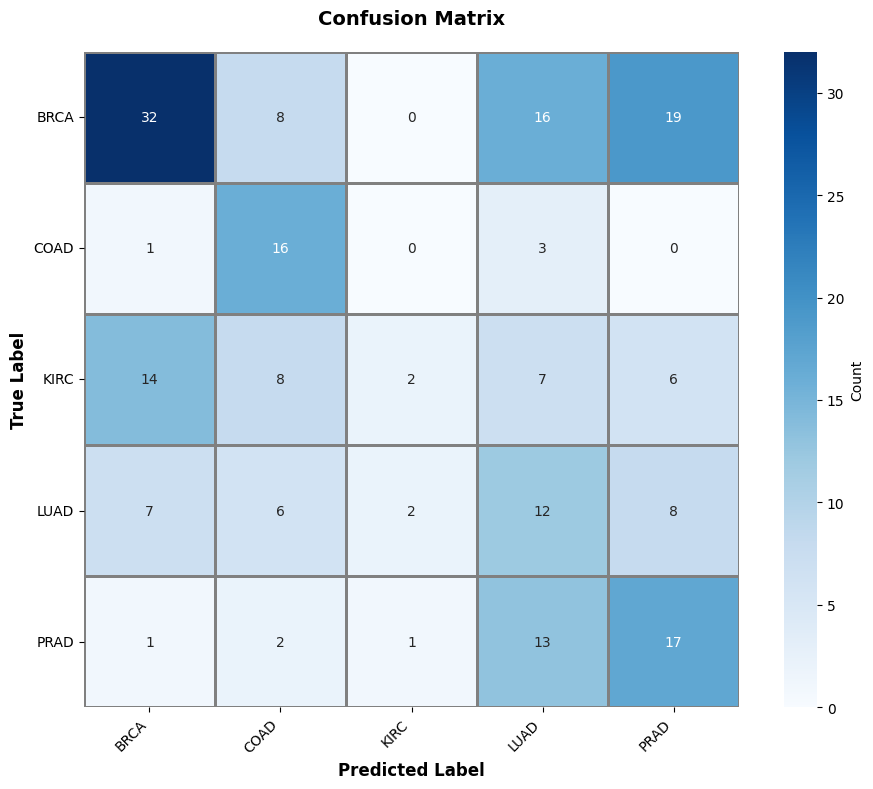

array([[32,  8,  0, 16, 19],
       [ 1, 16,  0,  3,  0],
       [14,  8,  2,  7,  6],
       [ 7,  6,  2, 12,  8],
       [ 1,  2,  1, 13, 17]])

In [23]:
X_train_rnn = np.expand_dims(X_train_balanced, axis=-1)  
X_test_rnn = np.expand_dims(X_test, axis=-1)

print(f"Train shape after reshape: {X_train_rnn.shape}")
print(f"Test shape after reshape: {X_test_rnn.shape}")

class_names = le.classes_
num_classes = len(class_names)
y_train_cat = to_categorical(y_train_balanced, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build SimpleRNN Model (consistent with Scenario 1 & 3)
model_7 = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(
        X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    SimpleRNN(32),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training (consistent with your example - no early stopping)
print("\n=== Training SimpleRNN Model ===")
print(f"Training samples: {X_train_rnn.shape[0]}")
print(f"Test samples: {X_test_rnn.shape[0]}")

model_7.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=1)
print("="*80)

test_loss, test_acc = model_7.evaluate(X_test_rnn, y_test_cat, verbose=0)
print(f"Accuracy: {test_acc:.4f}")

y_pred_proba = model_7.predict(X_test_rnn)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nSimpleRNN Classifier (Scenario 2)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in class_names]))

plot_confusion_matrix(y_test, y_pred, class_names=class_names)

Hasil klasifikasi RNN:

**BRCA** → 64/75 benar (11 salah: 1 ke COAD, 2 ke KIRC, 3 ke LUAD, 5 ke PRAD)  
**COAD** → 12/20 benar (8 salah: 3 ke BRCA, 2 ke KIRC, 2 ke LUAD, 1 ke PRAD)  
**KIRC** → 28/37 benar (9 salah: 2 ke BRCA, 2 ke COAD, 2 ke LUAD, 3 ke PRAD)  
**LUAD** → 20/35 benar (15 salah: 6 ke BRCA, 1 ke COAD, 1 ke KIRC, 7 ke PRAD)  
**PRAD** → 33/34 benar (1 salah ke BRCA)

**Analisis:**

**BRCA (Kanker Payudara)**  
11 dari 75 sampel salah, tersebar ke semua kelas. RNN sudah bermasalah di Scenario 1, di Scenario 2 dengan synthetic samples tambahan jadi lebih parah. Arsitektur sequential RNN tidak cocok untuk data tabular, apalagi data yang sudah terkontaminasi noise.

**COAD (Kanker Usus Besar)**  
8 dari 20 salah - performa sangat buruk! Kombinasi synthetic samples berkualitas rendah + arsitektur RNN yang tidak cocok membuat COAD hampir tidak bisa dikenali dengan baik. Model seperti "menebak" daripada benar-benar belajar pola.

**KIRC (Kanker Ginjal)**  
9 kesalahan - padahal KIRC biasanya mudah dikenali. RNN yang memproses fitur secara sequential malah kehilangan informasi penting tentang hubungan antar gen. Ditambah synthetic samples membuat semua jadi makin kacau.

**LUAD (Kanker Paru)**  
Paling buruk! 15 dari 35 sampel salah, dengan 7 masuk ke PRAD. RNN benar-benar tidak mampu menangani kompleksitas LUAD di scenario dengan synthetic balancing. Model cenderung bias ke kelas dominan seperti BRCA dan PRAD.

**PRAD (Kanker Prostat)**  
ada 1 kesalahan! Meski begitu, PRAD tetap yang paling baik di RNN. Polanya sangat kuat sehingga meski arsitektur tidak optimal, masih bisa dikenali dengan cukup baik.

**Kesimpulan:**  
RNN hanya mencapai akurasi 78% - yang terburuk dari semua model. Kombinasi arsitektur yang tidak cocok untuk data tabular + noise dari synthetic samples membuat RNN sangat tidak efektif di Scenario 2.